# simulate signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
t = np.linspace(0, 10, 9001)

In [3]:
x_volts = 0.5*t + np.sin(np.pi*t) + np.sin(2*np.pi*t) +  np.sin(6*np.pi*t)

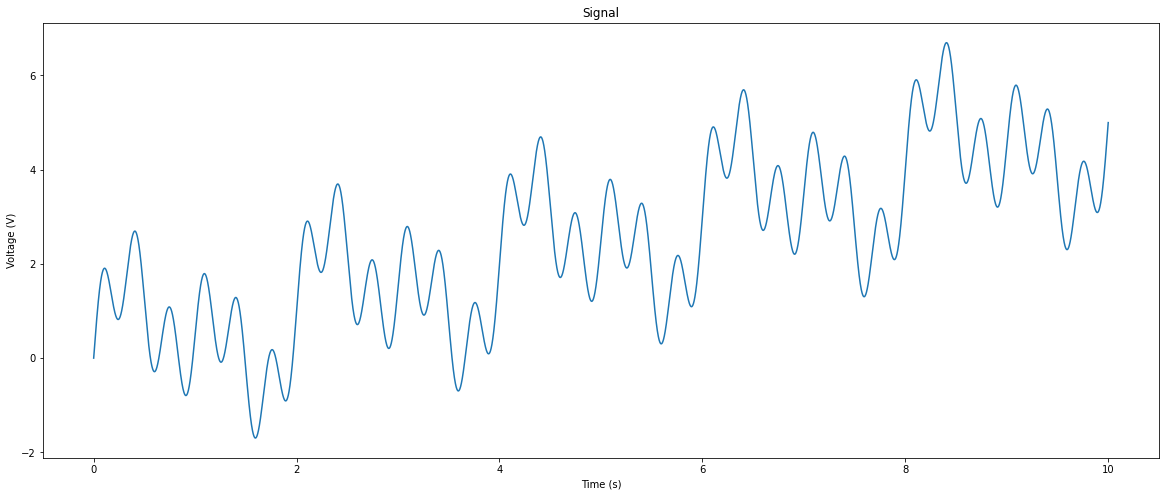

In [4]:
plt.figure(figsize = (20,8))
plt.plot(t, x_volts)
plt.title('Signal')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

# denoise

In [5]:
x_watts = x_volts ** 2

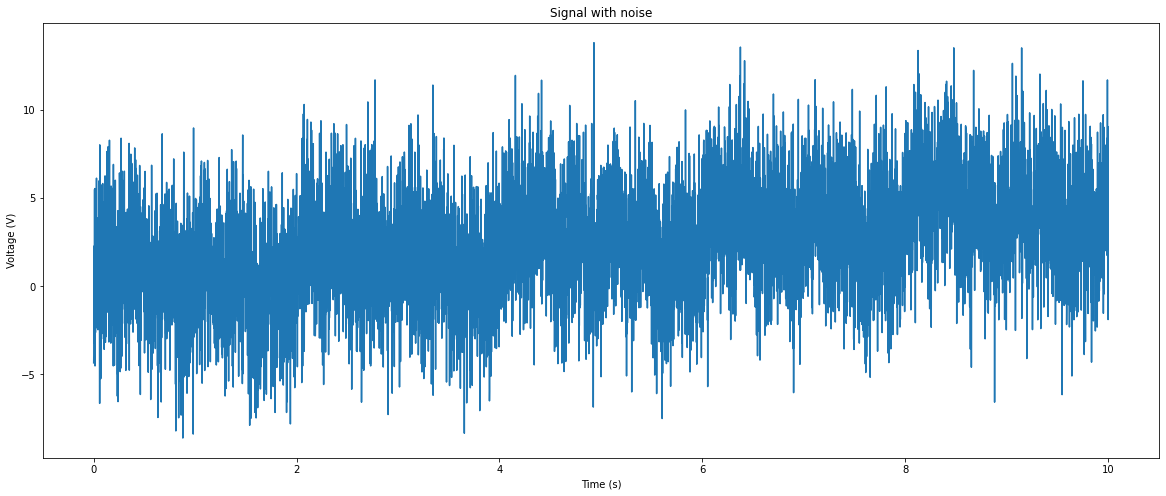

In [6]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 1
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

# Plot signal with noise
plt.figure(figsize = (20,8))
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

In [269]:
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation
import pandas as pd

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [9]:
y_volts.shape

(9001,)

In [10]:
x_volts.shape

(9001,)

In [14]:
y_voltsdf=pd.DataFrame(y_volts)
x_voltsdf=pd.DataFrame(x_volts)

In [15]:
def create_noisy(data,percentage=0.5,size=100):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [16]:
GSPC_pure=create_noisy(y_voltsdf)

GSPC_noisy=create_noisy(x_voltsdf)

In [17]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(46, 4500)
(46, 4500)


In [18]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [23]:
keras.backend.clear_session()

In [37]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1DTranspose(64, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same'))
    model.add(Conv1DTranspose(256, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 256)         1024      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          49216     
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, None, 64)         12352     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, None, 256)        49408     
 ranspose)                                                       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 1)           769       
                                                                 
Total params: 112,769
Trainable params: 112,769
Non-tr

In [38]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=0, callbacks=[callback])

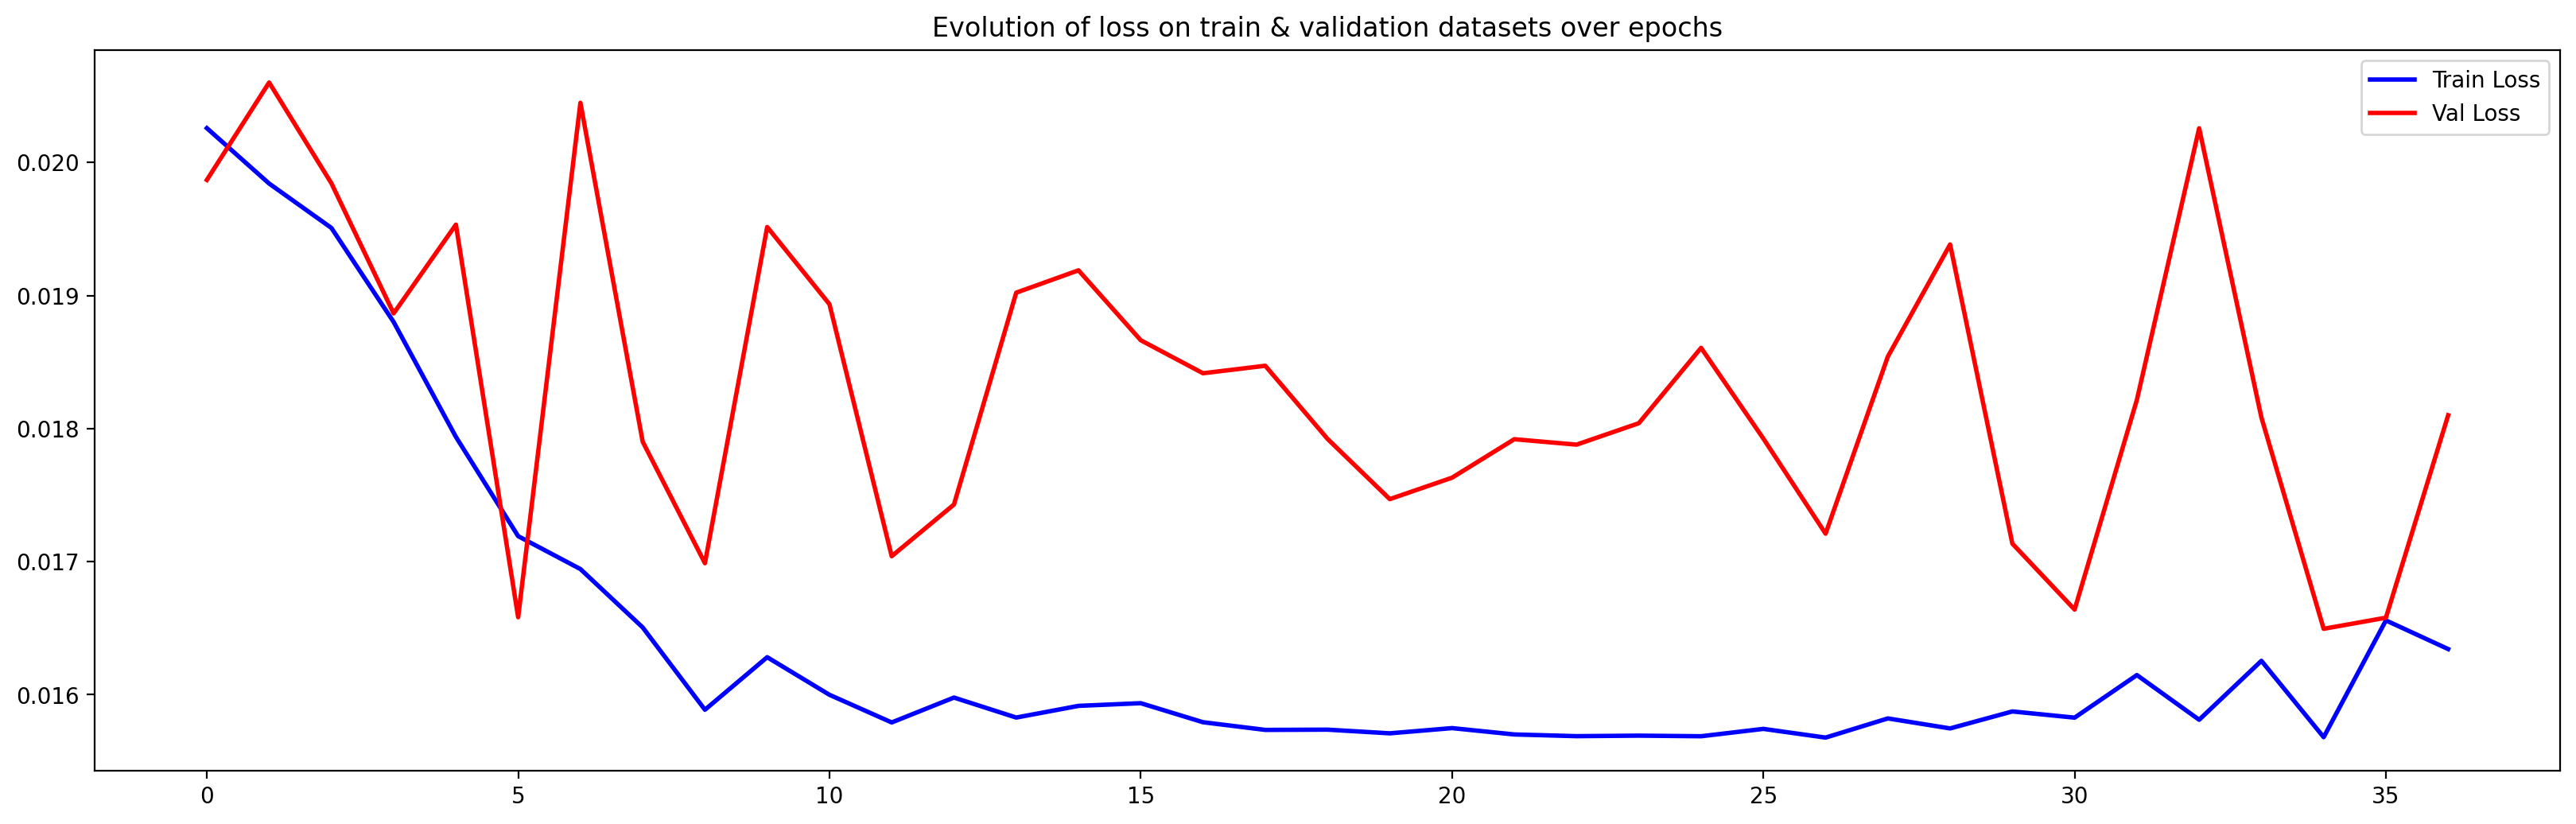

In [39]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [40]:
GSPC_test=x_voltsdf

1/1 [==============================] - 0s 97ms/step


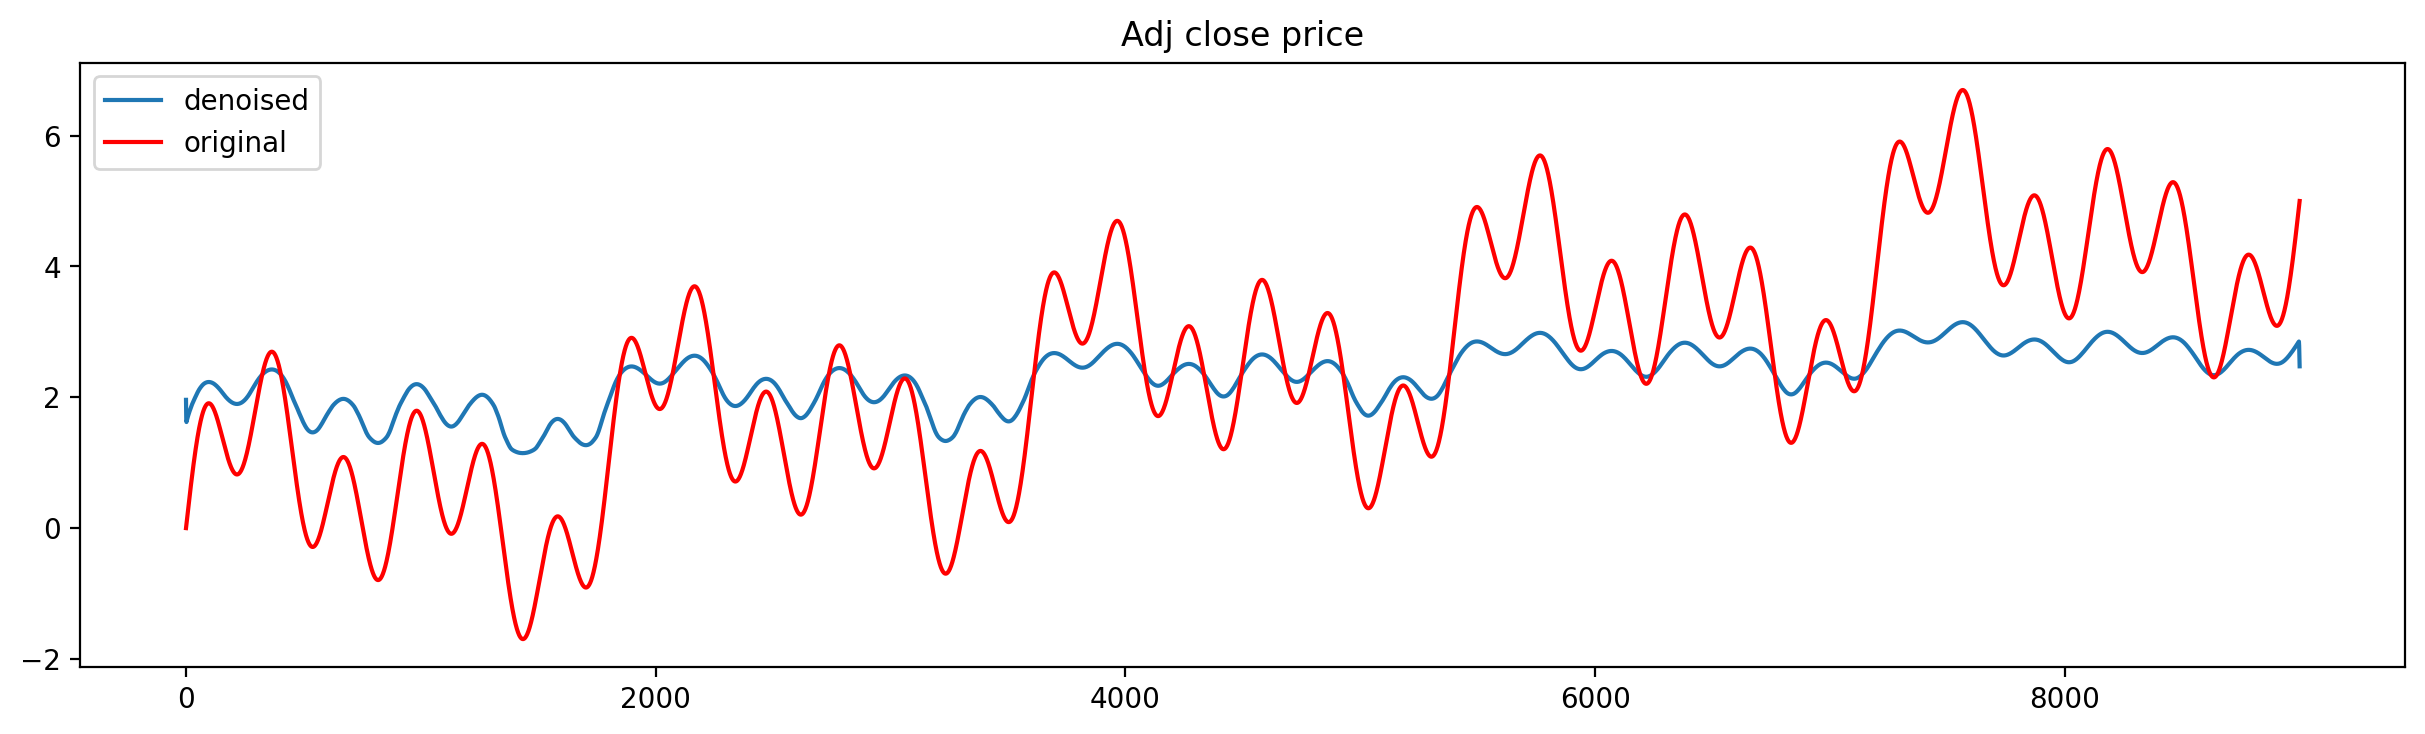

In [41]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

In [42]:
N = np.array(noise_volts)**2

In [43]:
SNR = 10 * np.log10(sum(x_watts)/sum(N))
print(SNR)

0.9656869409662112


In [44]:
R = np.array(pure_mm_cnn)**2

In [45]:
pure_mm_cnn

,Adj Close
0,1.960744
1,1.681566
2,1.621511
3,1.634109
4,1.651518
...,...
8996,2.847724
8997,2.852164
8998,2.784807
8999,2.604151


In [46]:
N1 = pure_mm_cnn['Adj Close'] - x_volts

In [47]:
N1_square = np.array(N1)**2

In [48]:
snr = 10 * np.log10(sum(R)/sum(N1_square))
print(snr)

[5.0016394]


In [270]:
# Initialization
decom = EMD()
#decom = EEMD()
#decom = CEEMDAN()
        
# Decompose
imfs_emd = decom(y_volts)

In [271]:
from PyEMD.checks import whitenoise_check
significant_imfs = whitenoise_check(imfs_emd)
significant_imfs

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1}

In [272]:
imfs_df = pd.DataFrame(imfs_emd.T)

In [273]:
imfs_df['denoised'] = imfs_df.iloc[:,6:].sum(axis = 1)

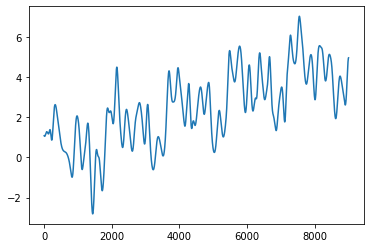

In [274]:
plt.plot(imfs_df['denoised'])

In [275]:
sum(x_watts)

83737.87835027796

In [276]:
N = np.array(noise_volts)**2

In [277]:
SNR = 10 * np.log10(sum(x_watts)/sum(N))
print(SNR)

1.0208351518783016


In [278]:
R = np.array(imfs_df['denoised'])**2

In [279]:
N1 = imfs_df['denoised'] - x_volts

In [280]:
N1_square = np.array(N1)**2

In [281]:
snr = 10 * np.log10(sum(R)/sum(N1_square))
print(snr)

18.514473050682554
